网格信息:
  - 维度: 2
  - 节点数: 1786
  - 单元数: 3172


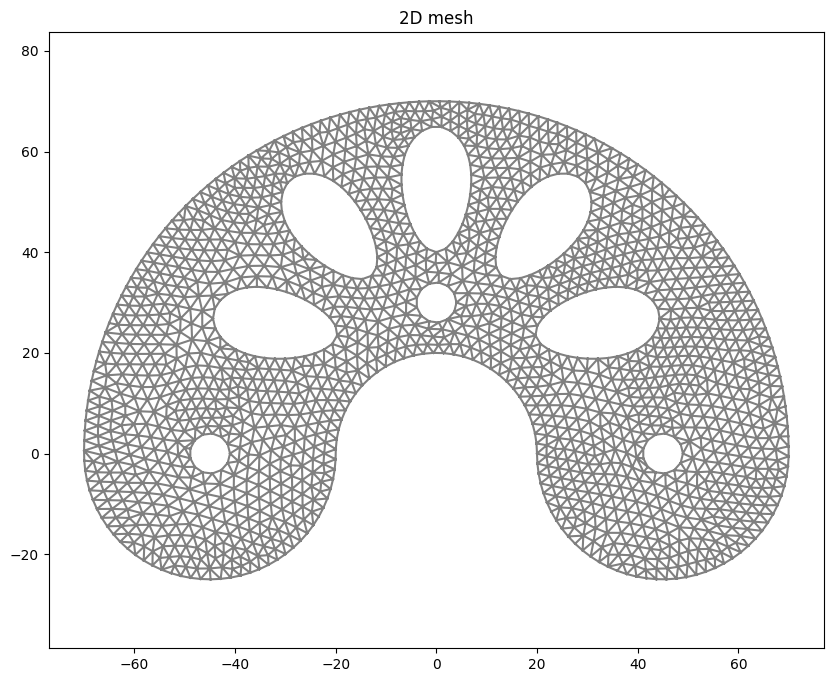

In [1]:
from dolfin import Mesh, XDMFFile, plot
import matplotlib.pyplot as plt

# 步骤1: 使用DOLFIN读取XML文件
xml_input = 'input/topo_shape.xml'
mymesh = Mesh(xml_input)

print(f"网格信息:")
print(f"  - 维度: {mymesh.geometric_dimension()}")
print(f"  - 节点数: {mymesh.num_vertices()}")
print(f"  - 单元数: {mymesh.num_cells()}")

# 步骤2: 显示网格
plt.figure(figsize=(10, 8))
plot(mymesh)
plt.title("2D mesh")
plt.axis('equal')
plt.show()

In [125]:
from fenics import *
# 定义函数空间
V = VectorFunctionSpace(mymesh, "CG", 1)

# 定义边界条件
def left_boundary(x, on_boundary):
    x_min = min(x[0] for x in mymesh.coordinates())
    return on_boundary and x[0] <= x_min + 5

# 左侧固定边界条件
bc = DirichletBC(V, Constant((0, 0)), left_boundary)


# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        x_max = max(x[0] for x in mymesh.coordinates())
        return on_boundary and x[0] >= x_max - 5
right_end_boundary = RightEnd()

boundary_mark = MeshFunction("size_t", mymesh, mymesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary_id = 1
right_end_boundary.mark(boundary_mark, right_end_boundary_id)

# 定义问题
u = TrialFunction(V)
v = TestFunction(V)


In [126]:
#  材料参数 (假设为线性弹性材料)
E = Constant(1e5)  # 杨氏模量
nu = Constant(0.3)  # 泊松比
mu = E / (2 * (1 + nu))
lmbda = E * nu / ((1 + nu) * (1 - 2 * nu))

In [127]:
# 应变和应力
def epsilon(u):
    return 0.5 * (grad(u) + grad(u).T)

def sigma(u):
    return lmbda * tr(epsilon(u)) * Identity(2) + 2 * mu * epsilon(u)

# 变分形式
a = inner(sigma(u), epsilon(v)) * dx

# 右侧施加的力
f = Constant((500.0, 0.0))
L = dot(f, v) * ds(subdomain_data=boundary_mark, domain=mymesh, subdomain_id=right_end_boundary_id)

In [128]:
# 求解问题
u = Function(V)
solve(a == L, u, bc)

# 计算von Mises应力
stress = sigma(u) - (1./3)*tr(sigma(u))*Identity(2)  # 偏应力张量
von_mises = sqrt(3./2*inner(stress, stress))
V_scalar = FunctionSpace(mymesh, "CG", 1)
von_mises_proj = project(von_mises, V_scalar)


Solving linear variational problem.


In [129]:
# 绘制结果
plt.figure(figsize=(12, 5), dpi=1000)

# 变形图
plt.subplot(121)
c1 = plot(u, title='Displacement', mode='displacement')
plt.colorbar(c1, label='Displacement magnitude')

# von Mises应力图
plt.subplot(122)
c2 = plot(von_mises_proj, title='von Mises stress')
plt.colorbar(c2, label='Stress magnitude')

plt.tight_layout()
plt.show()

# 打印最大位移和最大von Mises应力
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607


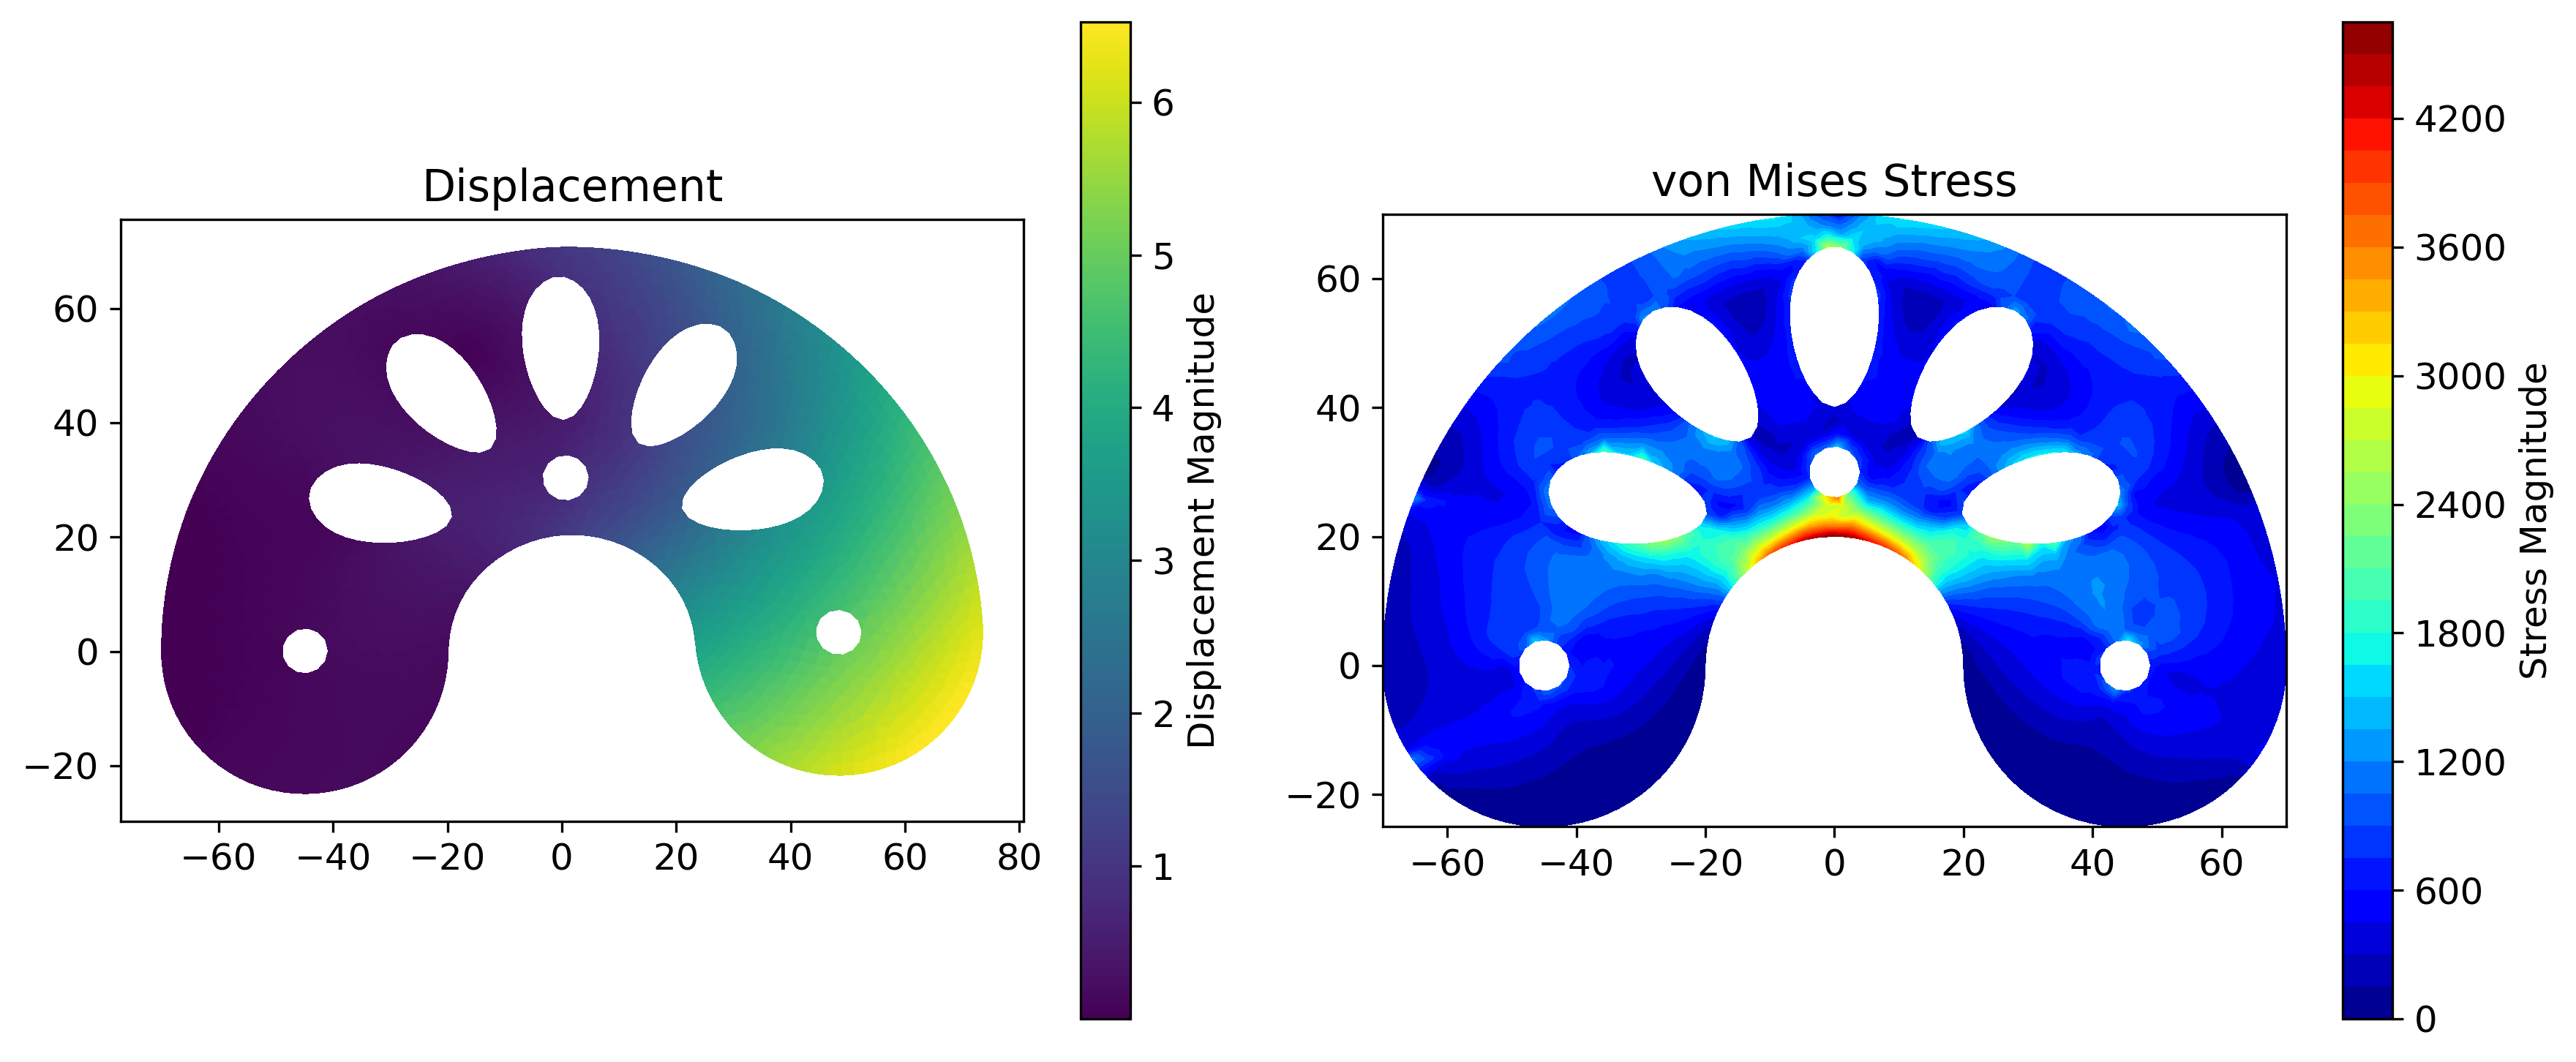

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607
Figures displayed


In [130]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 绘制结果
plt.figure(figsize=(12, 5), dpi=300)

# 变形图
plt.subplot(121)
c1 = plot(u, title='Displacement', mode='displacement', cmap='viridis')
plt.colorbar(c1, label='Displacement Magnitude')
# plt.grid(True, linestyle='--', alpha=0.7)

# von Mises应力图
plt.subplot(122)
c2 = plot(von_mises_proj, title='von Mises Stress', cmap='jet')
plt.colorbar(c2, label='Stress Magnitude')
# plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 打印最大位移和最大von Mises应力
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

print("Figures displayed")

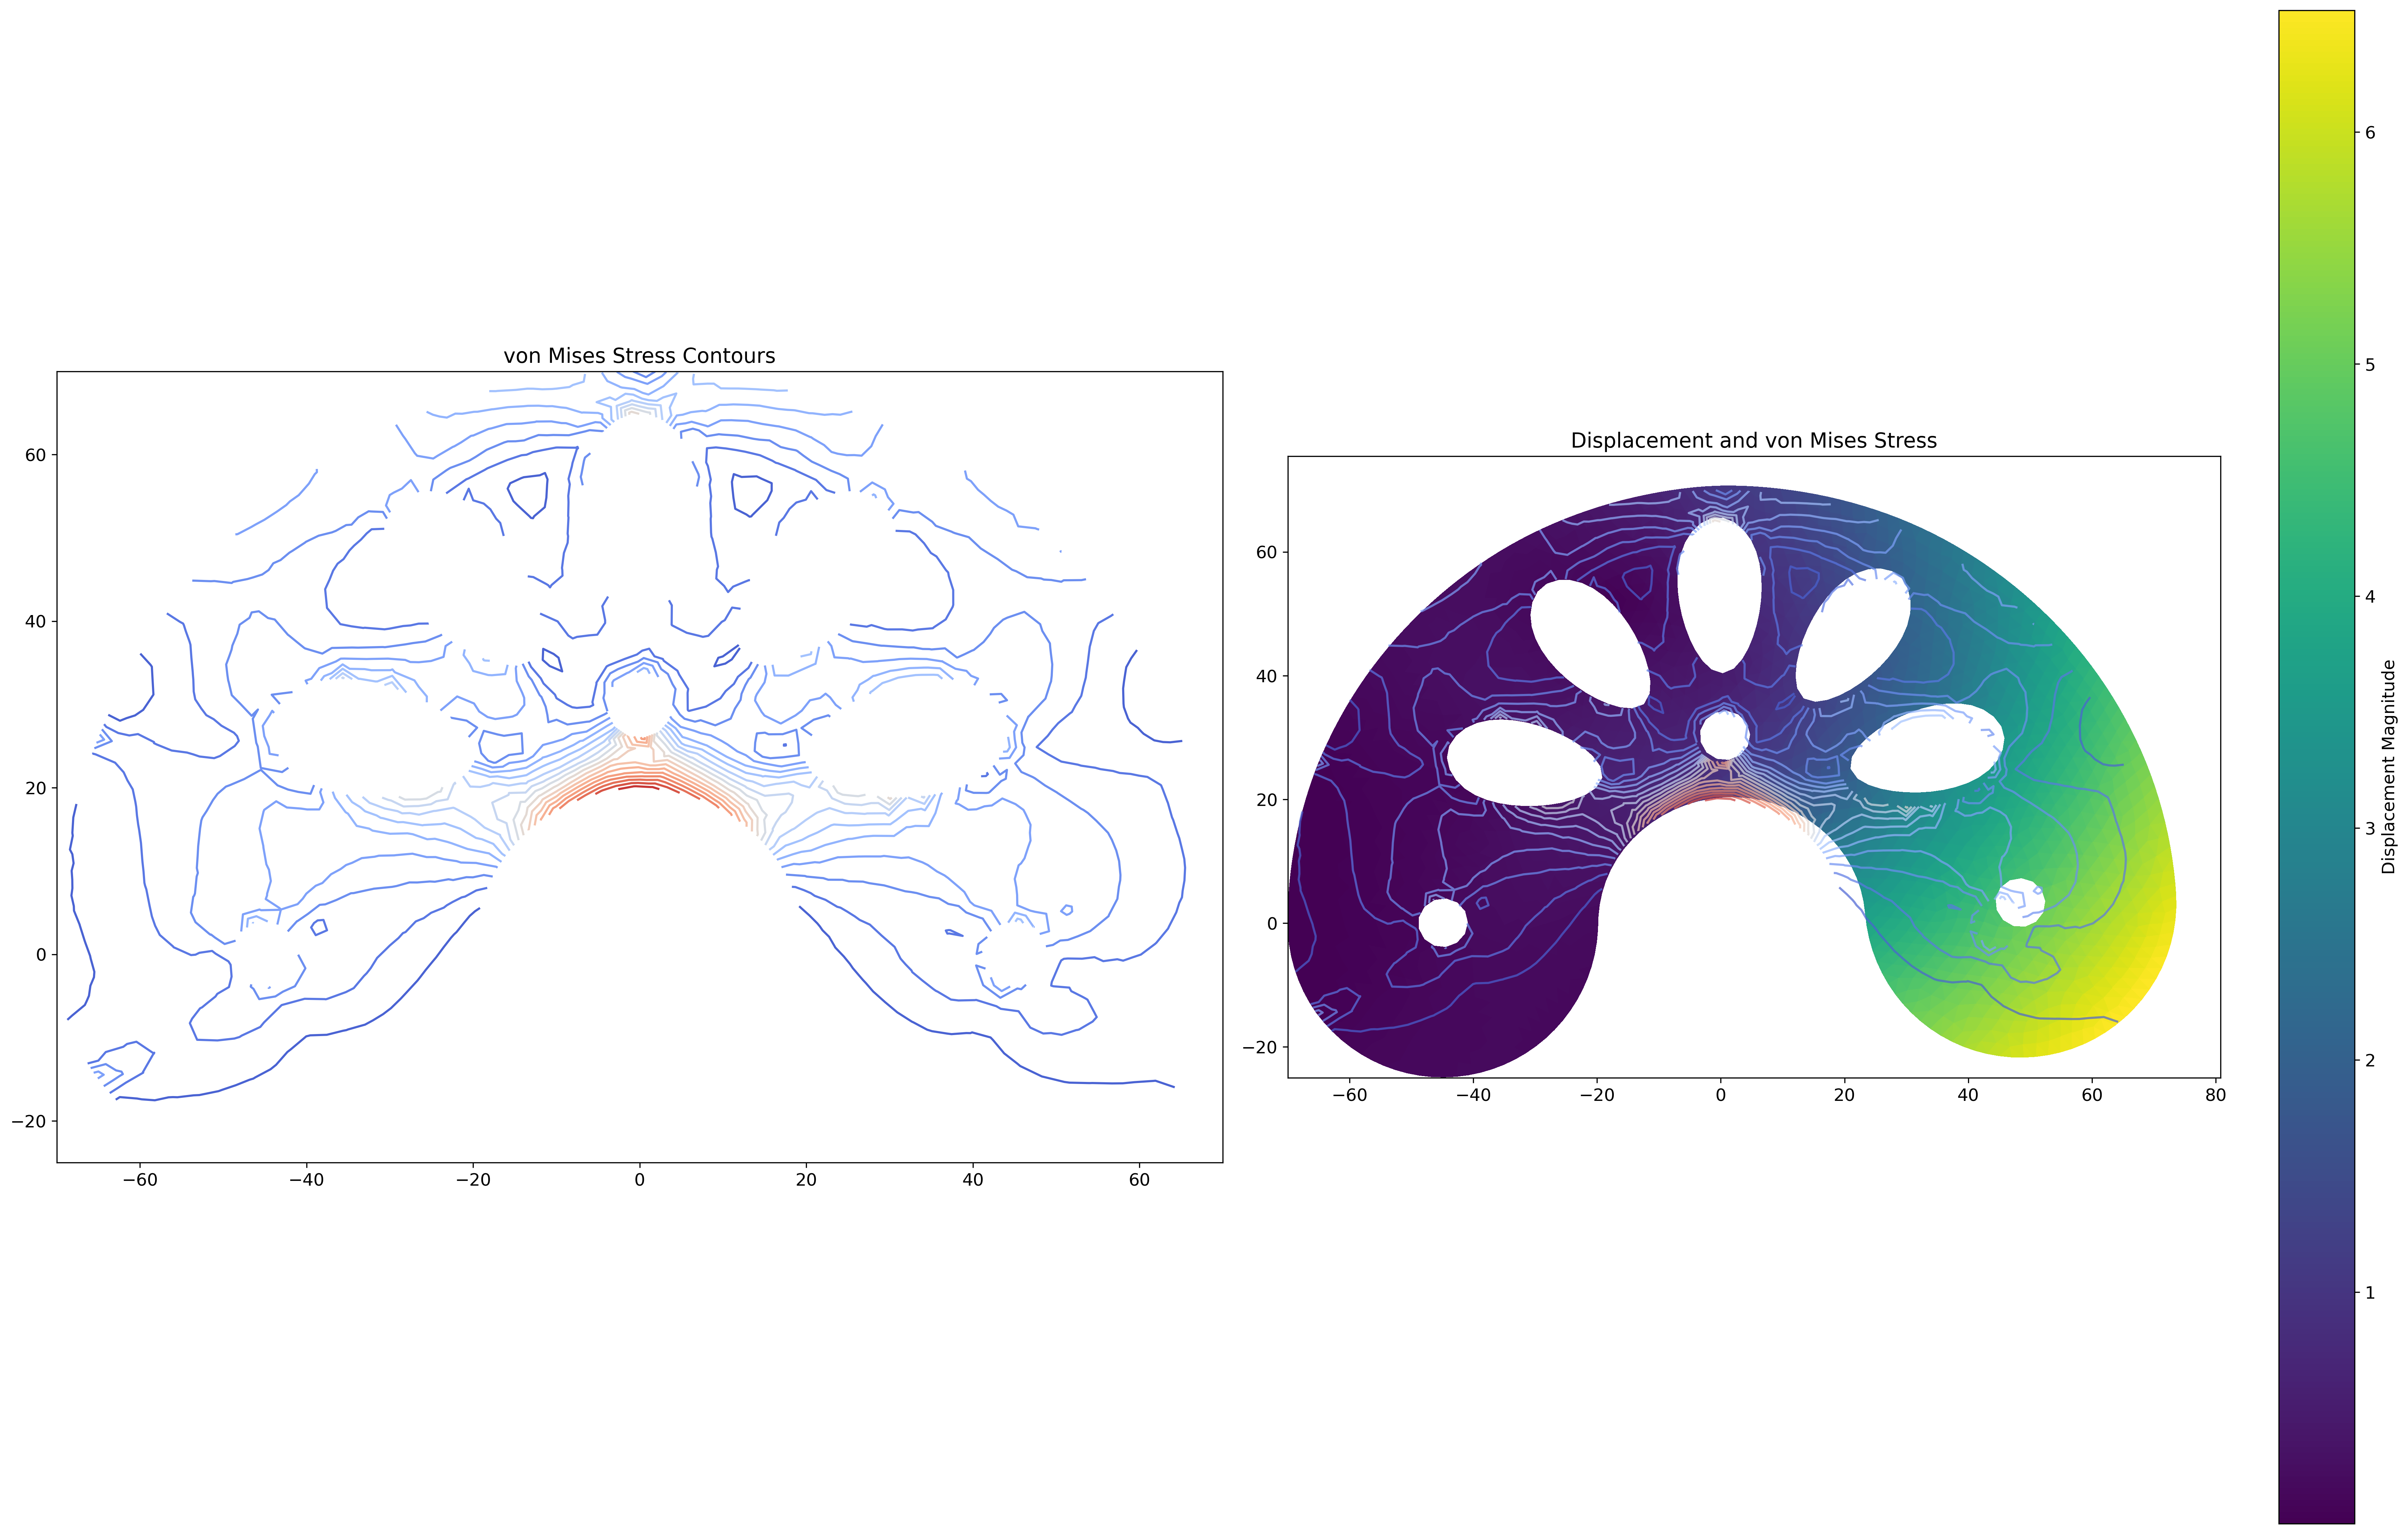

Maximum displacement: 5.2183
Maximum von Mises stress: 4622.5607
Figures displayed
我们创建了两个图表来展示分析结果：
1. von Mises应力等值线图：清晰地显示了应力集中的区域
2. 组合图：同时显示位移和应力，便于观察它们之间的关系
这种展示方法有助于我们更好地理解和分析结构的行为。


In [131]:
# Set global font size
plt.rcParams.update({'font.size': 12})

# Plot results
plt.figure(figsize=(24, 15), dpi=300)

# von Mises stress contour plot
plt.subplot(121)
c3 = plot(von_mises_proj, title='von Mises Stress Contours', mode='contour', levels=20, cmap='coolwarm')

# Combined plot: Displacement and von Mises stress
plt.subplot(122)
c4 = plot(u, title='Displacement and von Mises Stress', mode='displacement', cmap='viridis')
plt.colorbar(c4, label='Displacement Magnitude')
# c5 = plot(von_mises_proj, cmap='coolwarm')
c6 = plot(von_mises_proj, mode='contour', levels=20, cmap='coolwarm', alpha=0.7)


plt.tight_layout()
plt.show()

# Print maximum displacement and maximum von Mises stress
print(f"Maximum displacement: {u.vector().max():.4f}")
print(f"Maximum von Mises stress: {von_mises_proj.vector().max():.4f}")

print("Figures displayed")

# 解释两个图表
print("我们创建了两个图表来展示分析结果：")
print("1. von Mises应力等值线图：清晰地显示了应力集中的区域")
print("2. 组合图：同时显示位移和应力，便于观察它们之间的关系")
print("这种展示方法有助于我们更好地理解和分析结构的行为。")


In [156]:
# 获取每个网格顶点处的应力张量值
import numpy as np
stress_tensor = project(sigma(u), TensorFunctionSpace(mymesh, 'DG', 0))

In [167]:
# 计算每个顶点的最大主应力
principal_stresses = [0] * mymesh.num_vertices()

# 遍历每个顶点，计算s_matrix的特征值和特征向量
for i in range(mymesh.num_vertices()):
    s = stress_tensor(mymesh.coordinates()[i])
    s_matrix = np.array([[s[0], s[1]], [s[2], s[3]]])
    eigvals, eigvecs = np.linalg.eig(s_matrix)
    # print(f"网格顶点编号为{i}的顶点处的特征值: {eigvals}")
    # print(f"网格顶点编号为{i}的顶点处的特征向量: {eigvecs}")
  
# 打印顶点1处的特征值特征向量
s_vertex_1 = stress_tensor(mymesh.coordinates()[1])
s_matrix_vertex_1 = np.array([[s_vertex_1[0], s_vertex_1[1]], [s_vertex_1[2], s_vertex_1[3]]])
eigvals_vertex_1, eigvecs_vertex_1 = np.linalg.eig(s_matrix_vertex_1)
print(f"顶点1处的特征值: {eigvals_vertex_1}")
print(f"顶点1处的特征向量: {eigvecs_vertex_1}")

# 找到最大特征值及其对应的特征向量
max_eigval_index = np.argmax(eigvals_vertex_1)
max_eigval = eigvals_vertex_1[max_eigval_index]
max_eigvec = eigvecs_vertex_1[:, max_eigval_index]
print(f"最大特征值: {max_eigval}")
print(f"对应的特征向量: {max_eigvec}")

# 提取每个网格顶点处最大特征值对应的特征向量
max_principal_stresses = [0] * mymesh.num_vertices()
max_principal_directions = [0] * mymesh.num_vertices()

for i in range(mymesh.num_vertices()):
    s = stress_tensor(mymesh.coordinates()[i])
    s_matrix = np.array([[s[0], s[1]], [s[2], s[3]]])
    eigvals, eigvecs = np.linalg.eig(s_matrix)
    max_eigval_index = np.argmax(eigvals)
    max_principal_stresses[i] = eigvals[max_eigval_index]
    max_principal_directions[i] = eigvecs[:, max_eigval_index]

# 打印前几个顶点的最大特征值及其对应的特征向量
for i in range(min(5, mymesh.num_vertices())):
    print(f"顶点{i}处的最大特征值: {max_principal_stresses[i]}")
    print(f"顶点{i}处的对应特征向量: {max_principal_directions[i]}")

顶点1处的特征值: [-10.93139658 -23.70678412]
顶点1处的特征向量: [[ 0.98795443  0.15474511]
 [-0.15474511  0.98795443]]
最大特征值: -10.931396584786318
对应的特征向量: [ 0.98795443 -0.15474511]
顶点0处的最大特征值: -3.606118606796926
顶点0处的对应特征向量: [ 0.78092701 -0.62462229]
顶点1处的最大特征值: -10.931396584786318
顶点1处的对应特征向量: [ 0.98795443 -0.15474511]
顶点2处的最大特征值: -8.25840366477874
顶点2处的对应特征向量: [0.99943857 0.0335045 ]
顶点3处的最大特征值: -5.588413359257856
顶点3处的对应特征向量: [0.99168284 0.12870562]
顶点4处的最大特征值: -2.5069972765412274
顶点4处的对应特征向量: [0.97814725 0.20791335]


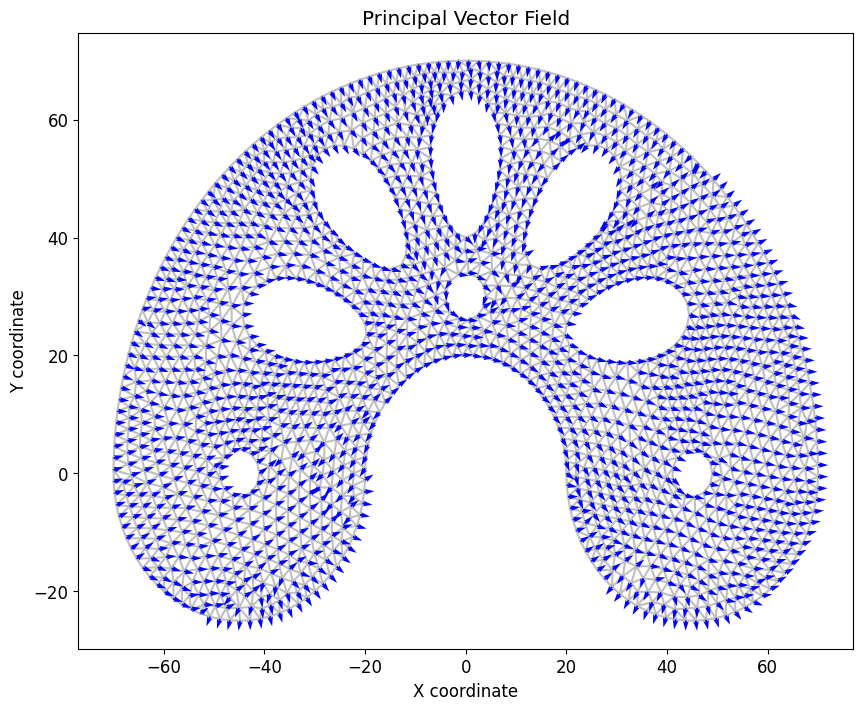

In [169]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# 提取网格顶点坐标
vertices = mymesh.coordinates()

# 提取最大特征值对应的特征向量的x和y分量
max_principal_directions_x = [vec[0] for vec in max_principal_directions]
max_principal_directions_y = [vec[1] for vec in max_principal_directions]

# 创建三角剖分对象
triangulation = tri.Triangulation(vertices[:, 0], vertices[:, 1], mymesh.cells())

# 绘制向量场
plt.figure(figsize=(10, 8))
plt.triplot(triangulation, color='gray', alpha=0.5)
plt.quiver(vertices[:, 0], vertices[:, 1], max_principal_directions_x, max_principal_directions_y, color='blue')
plt.title('Principal Vector Field')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.show()


In [175]:
def map_vector_field_to_point(x, y, vertices, directions):
    """
    将向量场映射到网格中的任意一点
    :param x: 点的x坐标
    :param y: 点的y坐标
    :param vertices: 网格顶点坐标
    :param directions: 每个顶点处的向量方向
    :return: 点(x, y)处的向量方向
    """
    # 计算点(x, y)到每个顶点的距离
    distances = np.sqrt((vertices[:, 0] - x) ** 2 + (vertices[:, 1] - y) ** 2)
    
    # 找到距离最近的顶点
    nearest_vertex_index = np.argmin(distances)
    
    # 返回最近顶点处的向量方向
    return directions[nearest_vertex_index]

# 示例使用
x, y = 1.0, 1.0  # 任意点的坐标
direction_at_point = map_vector_field_to_point(x, y, vertices, max_principal_directions)
print(f"点({x}, {y})处的向量方向: {direction_at_point}")



点(1.0, 1.0)处的向量方向: [ 0.78574618 -0.61854906]
